Links:
- [imports](#imports)
- [investigate one wearable](#one_wearable)
- [Read and Sleep Detector](#read_and_sleep_detector)
- [Physical Activity](#physical_activity)
- [Demographics](#demographics)
- [Sequence Length Distribution](#sequence_length)


# Imports <a id='imports'></a>

In [1]:
%matplotlib inline

In [2]:
import time
import functools
import sys
import pandas as pd
import numpy as np
from glob import glob
from hypnospy import Wearable, Experiment, Demographics
from hypnospy.data import MESAPreProcessing, HCHSPreProcessing
from hypnospy.analysis import NonWearingDetector, SleepBoudaryDetector, Viewer, PhysicalActivity, Validator, \
    CircadianAnalysis
from hypnospy.analysis import SleepMetrics, SleepWakeAnalysis

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


def setup_experiment(preprocessor, file_path, start_hour):
    # Configure an Experiment
    exp = Experiment()

    # Iterates over a set of files in a directory.
    # Unfortunately, we have to do it manually with RawProcessing because we are modifying the annotations
    for file in tqdm(glob(file_path)):

        pp = preprocessor(file)
        w = Wearable(pp)  # Creates a wearable from a pp object
        # Invert the two_stages flag. Now True means sleeping and False means awake

        w.data["interval_sleep"] = w.data["interval"].isin(["REST-S", "REST"])
        w.data["sleep"] = ~w.data["wake"].astype(bool)

        exp.add_wearable(w)
        exp.set_freq_in_secs(30)
        w.change_start_hour_for_experiment_day(start_hour)

    return exp

def check_time(t):
    now = time.process_time()
    print("Elapsed %.1f sec (=%.2f min):" % (now - t, (now - t)/60))
    return now



# Read and Sleep Detector <a id='read_and_sleep_detector'></a>

In [3]:

# options are: HCHS_SMALL, A_SMALL, HCHS, MESA
DATA_COLLECTION = "HCHS_SMALL" # sys.argv[1]
# DATA_COLLECTION = "MESA"

if DATA_COLLECTION == "MESA_SMALL":
    file_path = "../data/small_collection_mesa/*.csv"

elif DATA_COLLECTION == "MESA":
    file_path = "../data/collection_mesa_actigraphy/*.csv"

elif DATA_COLLECTION == "HCHS_SMALL":
    file_path = "../data/small_collection_hchs/*.csv"

elif DATA_COLLECTION == "HCHS":
    file_path = "../data/collection_hchs_actigraphy/*.csv"

if DATA_COLLECTION in ["MESA", "MESA_SMALL"]:
    preprocessor = MESAPreProcessing
    pid_col = "mesaid"
    path_to_demographics = "HypnosPy/data/demographics/mesa-sleep-dataset-0.3.0.csv"
    variables = ['race1c', 'gender1', 'sleepage5c', 'wkendsleepdur5t', 'nap5', 'trbleslpng5', 'wakeup5',
                 'wakeearly5', 'bcksleep5', 'slpngpills5', 'irritable5', 'sleepy5', 'typicalslp5', 'readng5',
                 'tv5', 'sittng5', 'riding5', 'lyngdwn5', 'talkng5', 'quietly5', 'car5', 'dinner5', 'driving5',
                 'snored5', 'stpbrthng5', 'legsdscmfrt5', 'rubbnglgs5', 'wrserest5', 'wrseltr5', 'feelngbstr5',
                 'tired5', 'mosttired4', 'feelngbstpk5', 'types5', 'slpapnea5', 'cpap5', 'dntaldv5', 'uvula5',
                 'insmnia5', 'rstlesslgs5', 'wrksched5', 'extrahrs5', 'whiirs5c', 'epslpscl5c', 'hoostmeq5c']
    clock_variables = None

elif DATA_COLLECTION in ["HCHS", "HCHS_SMALL"]:
    preprocessor = HCHSPreProcessing
    pid_col = "PID"
    path_to_demographics = "HypnosPy/data/demographics/hchs-dataset-0.5.0-merged.csv"
    variables = ['FLAG_NARC', 'FLAG_AHIGT50', 'FLAG_AGEGE65', "AGE", "GENDERNUM", "AGEGROUP_C2",
                 "AGEGROUP_C2_SUENO", "AGEGROUP_C5_SUENO", "AGEGROUP_C6", "AGEGROUP_C6_NHANES", "AGE_SUENO",
                 "COMMUTEHOME", "COMMUTEWORK", "EDUCATION_C2", "EDUCATION_C3", "EMPLOYED", "INCOME", "INCOME_C3",
                 "INCOME_C5", "MARITAL_STATUS", "N_HC", "OCCUPATION_CURR", "OCCUPATION_LONG", "SHIFT_LENGTH",
                 "SHIFTWORKERYN", "TOTCOMMUTE_DAY", "TOTCOMMUTE_WEEK", "WORK_HRS_DAY", "WORK_HRS_WEEK",
                 "ALCOHOL_USE_DISORDER", "ALCOHOL_USE_LEVEL", "CDCR", "CDCR_SUENO", "CHD_SELF", "CHD_SELF_SUENO",
                 "CIGARETTE_PACK_YEARS", "CIGARETTE_PACK_YEARS_C3", "CIGARETTES_YEAR", "CIGARETTE_USE",
                 "CLAUDICATION_INT", "CURRENT_SMOKER", "CVD_FRAME", "DIAB_DIAG", "DIABETES1", "DIABETES2",
                 "DIABETES2_INDICATOR", "DIABETES3", "DIABETES_C4", "DIABETES_LAB", "DIABETES_SELF",
                 "DIABETES_SELF_SUENO", "DIABETES_SUENO", "DIAB_FAMHIST", "DM_AWARE", "DM_AWARE_SUENO",
                 "DM_CONTROL", "DOCTOR_VISIT", "EVER_ANGINA_RELATIVE", "EVER_CABG_RELATIVE", "EVER_MI_RELATIVE",
                 "EXPOSURE_YEAR", "FH_CHD", "FH_STROKE", "FRAME_CVD_RISK_10YR", "HBA1C_SI", "HOMA_B", "HOMA_IR",
                 "HYPERT_AWARENESS", "HYPERT_CONTROL", "HYPERTENSION", "HYPERTENSION2", "HYPERTENSION_C4",
                 "HYPERTENSION_SUENO", "HYPERT_TREATMENT", "METS_IDF", "METS_NCEP", "METS_NCEP2", "MI_ECG",
                 "PRECHD_ANGINA", "PRECHD_NO_ANGINA", "STROKE", "STROKE_SUENO", "STROKE_TIA", "STROKE_TIA_SUENO",
                 "TOTALDRINKS_PER_WEEK", 'SLEA10', 'SLEA11', 'SLEA12A', 'SLEA12B', 'SLEA12C', 'SLEA12D', 'SLEA12E',
                 'SLEA12F', 'SLEA12G', 'SLEA12H', 'SLEA12I', 'SLEA12J', 'SLEA13', 'SLEA14', 'SLEA15', 'SLEA16',
                 'SLEA17', 'SLEA18', 'SLEA1A_2401', 'SLEA1C_2401', 'SLEA2A_2401', 'SLEA2C_2401', 'SLEA3', 'SLEA4',
                 'SLEA5', 'SLEA6', 'SLEA7', 'SLEA8', 'SLEA9', 'SPEA10', 'SPEA11', 'SPEA12A', 'SPEA12B', 'SPEA12C',
                 'SPEA12D', 'SPEA12E', 'SPEA12F', 'SPEA12G', 'SPEA12H', 'SPEA12I', 'SPEA12J', 'SPEA13', 'SPEA14',
                 'SPEA15', 'SPEA16', 'SPEA17', 'SPEA18', 'SPEA3', 'SPEA4', 'SPEA5', 'SPEA6', 'SPEA7', 'SPEA8',
                 'SPEA9', 'SQEA1', 'SQEA10', 'SQEA11', 'SQEA12', 'SQEA13', 'SQEA14', 'SQEA15', 'SQEA16', 'SQEA17',
                 'SQEA18', 'SQEA19', 'SQEA2', 'SQEA20', 'SQEA21', 'SQEA22', 'SQEA23', 'SQEA24', 'SQEA25', 'SQEA3',
                 'SQEA4', 'SQEA5', 'SQEA6', 'SQEA7', 'SQEA8', 'SQEA9']
    clock_variables = ["SLEA1A_2401", "SLEA1C_2401", "SLEA2A_2401", "SLEA2C_2401"]

start_hour = 15
min_consecutive_days = 5

print("Reading collection from disk...")
start = time.process_time()

exp = setup_experiment(preprocessor, file_path, start_hour)
exp.fill_no_activity(-0.0001)
exp.overall_stats()

elapsed_time = check_time(start)

# TODO: fix bug when annotation_merge_tolerance_in_minutes < 0
print("Sleep Boundary Detector...")
sbd = SleepBoudaryDetector(exp)
sbd.detect_sleep_boundaries(strategy="annotation", output_col="sleep_period_annotation",
                            annotation_col="interval_sleep",
                            annotation_merge_tolerance_in_minutes=120, annotation_only_largest_sleep_period=True)


 20%|█████████████████████████████████████▍                                                                                                                                                     | 1/5 [00:00<00:00,  5.43it/s]

Reading collection from disk...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]
e:\development\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.8.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.


Total number of wearables: 5
Total number of days: 42
Avg. number of days: 8.40 (+-0.490). Max: 9, Min: 8.
Avg. number of epochs: 21593.00 (+-1292.640). Max: 22928, Min: 19945.
Elapsed 0.8 sec (=0.01 min):
Sleep Boundary Detector...


e:\development\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.8.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
e:\development\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.8.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
e:\development\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.8.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
e:\development\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.8.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
e:\development\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.8.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.


# Validation

In [4]:

elapsed_time = check_time(elapsed_time)
print("Validation process...")
va = Validator(exp)
va.flag_epoch_physical_activity_less_than(min_activity_threshold=0)
va.flag_epoch_null_cols(col_list=["hyp_act_x"])

# nwd = NonWearingDetector(exp)
# nwd.detect_non_wear(strategy="choi", wearing_col="hyp_wearing_choi")
# va.flag_epoch_nonwearing("hyp_wearing_choi")

va.flag_day_sleep_length_less_than(sleep_period_col="sleep_period_annotation", min_sleep_in_minutes=3 * 30)
# n_removed_days = va.remove_flagged_days()
# print("Removed %d days (short sleep)." % n_removed_days)

va.flag_day_sleep_length_more_than(sleep_period_col="sleep_period_annotation", max_sleep_in_minutes=12 * 60)
# n_removed_days = va.remove_flagged_days()
# print("Removed %d days (long sleep)." % n_removed_days)

va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3 * 10)
# va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3*60)
# n_removed_days = va.remove_flagged_days()
# print("Removed %d days (non wearing)." % n_removed_days)

va.flag_day_if_valid_epochs_smaller_than(valid_minutes_per_day=20 * 60)
# n_removed_days = va.remove_flagged_days()
# print("Removed %d days (few valid epochs)." % n_removed_days)

elapsed_time = check_time(elapsed_time)
print("Done flagging wearables")
va.validation_report()

n_removed_wearables = va.remove_wearables_without_valid_days()
print("Removed %d wearables." % n_removed_wearables)

va.flag_day_if_not_enough_consecutive_days(min_consecutive_days)
n_removed_days = va.remove_flagged_days()
print("Removed %d days that are not consecutive." % n_removed_days)
n_removed_wearables = va.remove_wearables_without_valid_days()
print("Removed %d wearables." % n_removed_wearables)

elapsed_time = check_time(elapsed_time)
print("Done removing wearables")

exp.overall_stats()


Elapsed 1.0 sec (=0.02 min):
Validation process...
Elapsed 0.6 sec (=0.01 min):
Done flagging wearables
Number of days removed due to InvCode.FLAG_DAY_SHORT_SLEEP: 5
Number of days removed due to InvCode.FLAG_DAY_LONG_SLEEP: 0
Number of days removed due to InvCode.FLAG_DAY_WITHOUT_DIARY: 0
Number of days removed due to InvCode.FLAG_DAY_NON_WEARING: 4
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_VALID_EPOCHS: 11
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_CONSECUTIVE_DAYS: 0
Total number of potential days to remove (may have overlaps): 20
Removed 0 wearables.
Flagging the following days as invalid for pid 29915385: 0,1,2,4,6
Removed 16 days that are not consecutive.
Removing wearable 29915385.
Removed 1 wearables.
Elapsed 1.1 sec (=0.02 min):
Done removing wearables
Total number of wearables: 4
Total number of days: 26
Avg. number of days: 6.50 (+-0.500). Max: 7, Min: 6.
Avg. number of epochs: 18637.25 (+-1499.592). Max: 20160, Min: 17002.


In [5]:
len(exp.get_all_wearables())

4

# ML Format

In [6]:

elapsed_time = check_time(elapsed_time)
print("Done showing overall stats")

va = Validator(exp)
va.flag_epoch_physical_activity_less_than(min_activity_threshold=0)
va.flag_epoch_null_cols(col_list=["hyp_act_x"])

# Setting day to ml representation -> days may not be of fixed lengths.
print("Changing experiment_day representation to ml_sequence")
exp_day_column = 'ml_sequence'
exp.create_day_sleep_experiment_day(sleep_col="sleep_period_annotation", new_col=exp_day_column)

elapsed_time = check_time(elapsed_time)
print("Done with creating the ml_sequence col")

va.flag_day_sleep_length_less_than(sleep_period_col="sleep_period_annotation", min_sleep_in_minutes=3 * 30)
va.flag_day_sleep_length_more_than(sleep_period_col="sleep_period_annotation", max_sleep_in_minutes=12 * 60)
va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3 * 10)
va.flag_day_if_valid_epochs_smaller_than(valid_minutes_per_day=20 * 60)

elapsed_time = check_time(elapsed_time)
print("Done with flagging new sequences")

n_removed_days = va.remove_flagged_days()
print("Removed additional %d invalid days." % n_removed_days)

va.flag_day_if_not_enough_consecutive_days(min_consecutive_days)
n_removed_days = va.remove_flagged_days()
print("Removed %d days that are not consecutive." % n_removed_days)

n_removed_wearables = va.remove_wearables_without_valid_days()
print("Removed %d wearables." % n_removed_wearables)

elapsed_time = check_time(elapsed_time)
print("Done removing wearables")

print("FINAL DATASET:")
exp.overall_stats()

elapsed_time = check_time(elapsed_time)
print("Done dataset preprocessing...")

Elapsed 0.0 sec (=0.00 min):
Done showing overall stats
Changing experiment_day representation to ml_sequence
Elapsed 0.0 sec (=0.00 min):
Done with creating the ml_sequence col
Elapsed 0.4 sec (=0.01 min):
Done with flagging new sequences
Removed additional 8 invalid days.
Removed 0 days that are not consecutive.
Removed 0 wearables.
Elapsed 0.0 sec (=0.00 min):
Done removing wearables
FINAL DATASET:
Total number of wearables: 4
Total number of days: 22
Avg. number of days: 5.50 (+-0.500). Max: 6, Min: 5.
Avg. number of epochs: 15887.75 (+-1455.079). Max: 17370, Min: 14399.
Elapsed 0.0 sec (=0.00 min):
Done dataset preprocessing...


In [7]:
len(exp.get_all_wearables())

4

In [8]:
min_consecutive_days

5

# Investigate one wearable <a id='one_wearable'></a>

In [9]:
start_hour = 15
min_consecutive_days = 5


def investigate_one_wearable(wid):
    w0 = setup_experiment(MESAPreProcessing, '../../mesa/actigraphy/mesa-sleep-' + wid + '.csv', start_hour)

    w0.fill_no_activity(-0.0001)
    w0.overall_stats()

    print("Sleep Boundary Detector...")
    sbd = SleepBoudaryDetector(w0)
    sbd.detect_sleep_boundaries(strategy="annotation", output_col="sleep_period_annotation",
                                annotation_col="interval_sleep",
                                annotation_merge_tolerance_in_minutes=120, annotation_only_largest_sleep_period=True)

    va = Validator(w0)

    va.flag_epoch_physical_activity_less_than(min_activity_threshold=0)
    va.flag_epoch_null_cols(col_list=["hyp_act_x"])
    va.flag_day_sleep_length_less_than(sleep_period_col="sleep_period_annotation", min_sleep_in_minutes=3 * 30)
    va.flag_day_sleep_length_more_than(sleep_period_col="sleep_period_annotation", max_sleep_in_minutes=12 * 60)
    va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3 * 10)
    va.flag_day_if_valid_epochs_smaller_than(valid_minutes_per_day=16 * 60)

    va.validation_report()


    v = Viewer(w0)
    v.view_signals(["activity", "sleep"], 
                   sleep_cols=["sleep_period_annotation"],
                   text=["validation"],
                   alphas={'sleep': 0.3})

    n_removed_wearables = va.remove_wearables_without_valid_days()
    va.flag_day_if_not_enough_consecutive_days(min_consecutive_days)
    n_removed_days = va.remove_flagged_days()
    n_removed_wearables = va.remove_wearables_without_valid_days()

    v = Viewer(w0)
    v.view_signals(["activity", "sleep"], 
                   sleep_cols=["sleep_period_annotation"],
                   text=["validation"],
                   alphas={'sleep': 0.3})

    print("Removed %d wearables." % n_removed_wearables)
    print("Removed %d days that are not consecutive." % n_removed_days)                           
    print("Removed %d wearables." % n_removed_wearables)
    
    # Setting day to ml representation -> days may not be of fixed lengths.
    print("Changing experiment_day representation to ml_sequence")
    exp_day_column = 'ml_sequence'
    w0.create_day_sleep_experiment_day(sleep_col="sleep_period_annotation", new_col=exp_day_column)
    
    v = Viewer(w0)
    v.view_signals_ml_format(["activity", "sleep"], 
                   sleep_cols=["sleep_period_annotation"],
                   alphas={'sleep': 0.3})

    w0.overall_stats()



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]
e:\development\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.8.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.


Total number of wearables: 1
Total number of days: 8
Avg. number of days: 8.00 (+-0.000). Max: 8, Min: 8.
Avg. number of epochs: 17834.00 (+-0.000). Max: 17834, Min: 17834.
Sleep Boundary Detector...
Number of days removed due to InvCode.FLAG_DAY_SHORT_SLEEP: 2
Number of days removed due to InvCode.FLAG_DAY_LONG_SLEEP: 0
Number of days removed due to InvCode.FLAG_DAY_WITHOUT_DIARY: 0
Number of days removed due to InvCode.FLAG_DAY_NON_WEARING: 1
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_VALID_EPOCHS: 3
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_CONSECUTIVE_DAYS: 0
Total number of potential days to remove (may have overlaps): 6


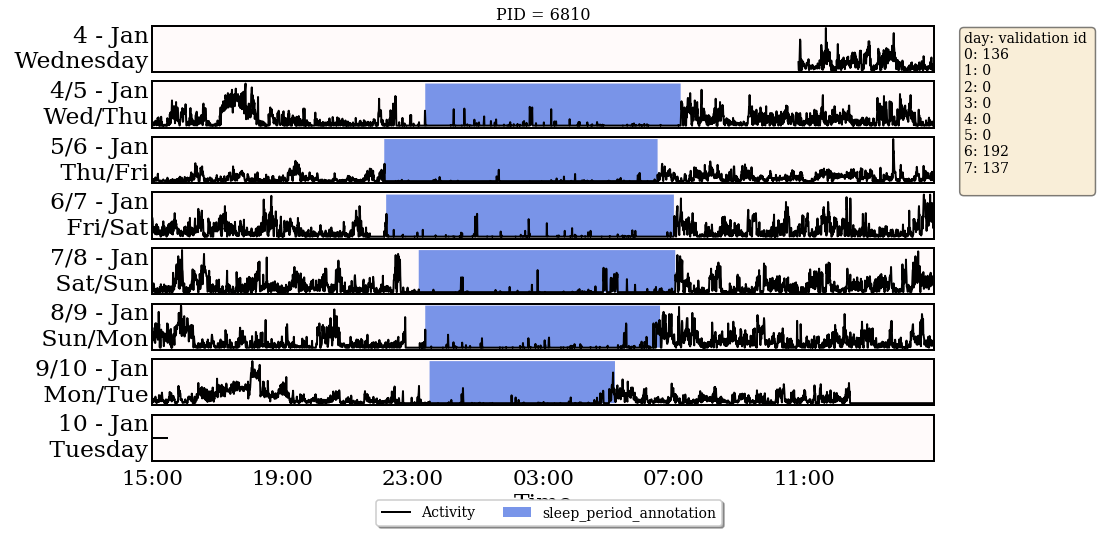

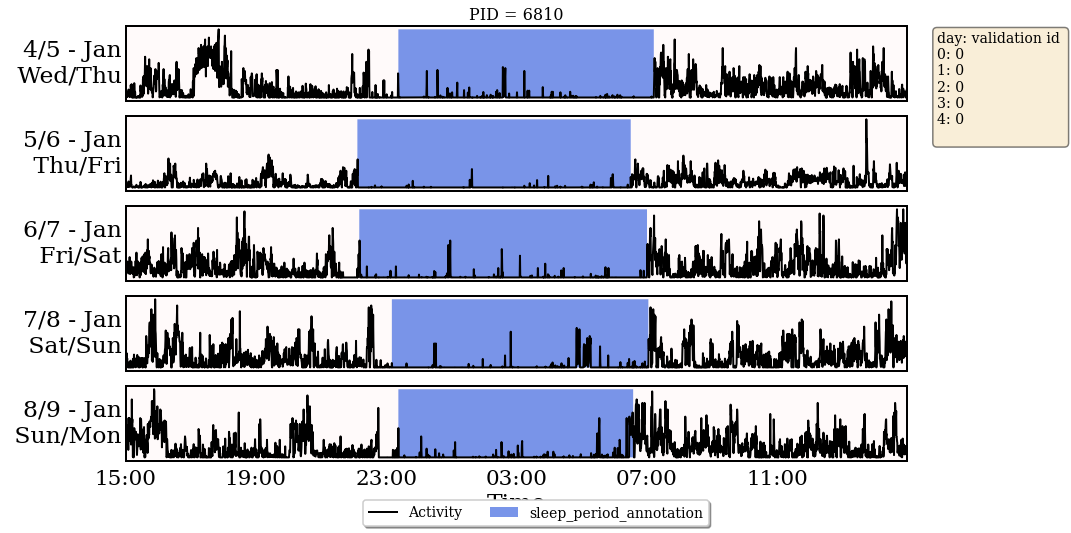

Removed 0 wearables.
Removed 3 days that are not consecutive.
Removed 0 wearables.
Changing experiment_day representation to ml_sequence


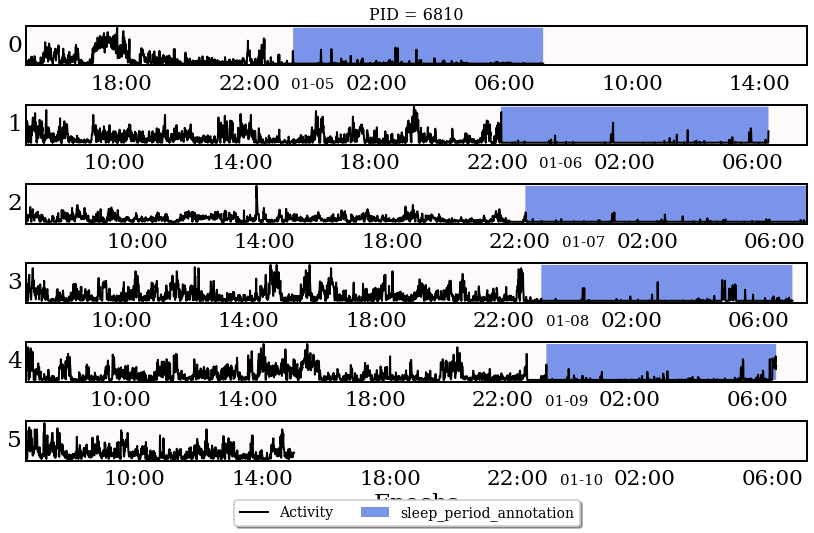

Total number of wearables: 1
Total number of days: 6
Avg. number of days: 6.00 (+-0.000). Max: 6, Min: 6.
Avg. number of epochs: 14400.00 (+-0.000). Max: 14400, Min: 14400.


In [10]:
investigate_one_wearable('6810')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]

Total number of wearables: 1
Total number of days: 8
Avg. number of days: 8.00 (+-0.000). Max: 8, Min: 8.
Avg. number of epochs: 20477.00 (+-0.000). Max: 20477, Min: 20477.
Sleep Boundary Detector...



e:\development\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.8.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.


Number of days removed due to InvCode.FLAG_DAY_SHORT_SLEEP: 1
Number of days removed due to InvCode.FLAG_DAY_LONG_SLEEP: 0
Number of days removed due to InvCode.FLAG_DAY_WITHOUT_DIARY: 0
Number of days removed due to InvCode.FLAG_DAY_NON_WEARING: 2
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_VALID_EPOCHS: 2
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_CONSECUTIVE_DAYS: 0
Total number of potential days to remove (may have overlaps): 5


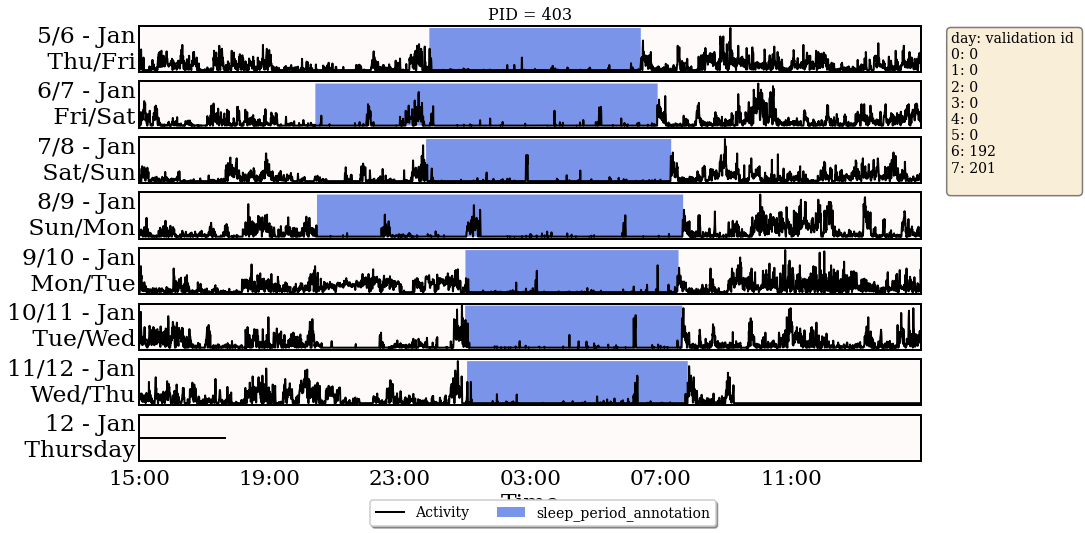

Removed 0 wearables.
Removed 2 days that are not consecutive.
Removed 0 wearables.
Changing experiment_day representation to ml_sequence


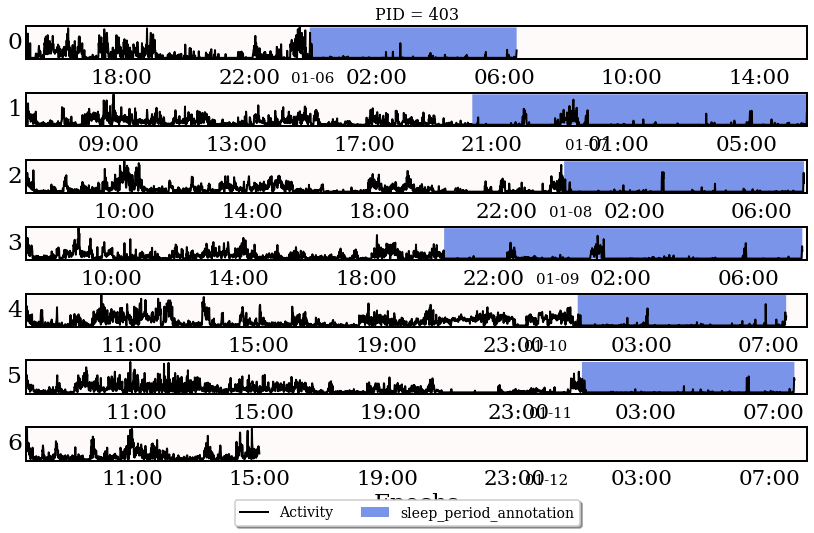

Total number of wearables: 1
Total number of days: 7
Avg. number of days: 7.00 (+-0.000). Max: 7, Min: 7.
Avg. number of epochs: 17280.00 (+-0.000). Max: 17280, Min: 17280.


In [11]:
w0 = setup_experiment(MESAPreProcessing, '../../mesa/actigraphy/mesa-sleep-' + '0403' + '.csv', start_hour)

w0.fill_no_activity(-0.0001)
w0.overall_stats()

print("Sleep Boundary Detector...")
sbd = SleepBoudaryDetector(w0)
sbd.detect_sleep_boundaries(strategy="annotation", output_col="sleep_period_annotation",
                            annotation_col="interval_sleep",
                            annotation_merge_tolerance_in_minutes=120, annotation_only_largest_sleep_period=True)

va = Validator(w0)

va.flag_epoch_physical_activity_less_than(min_activity_threshold=0)
va.flag_epoch_null_cols(col_list=["hyp_act_x"])
va.flag_day_sleep_length_less_than(sleep_period_col="sleep_period_annotation", min_sleep_in_minutes=3 * 30)
va.flag_day_sleep_length_more_than(sleep_period_col="sleep_period_annotation", max_sleep_in_minutes=12 * 60)
va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3 * 10)
va.flag_day_if_valid_epochs_smaller_than(valid_minutes_per_day=16 * 60)

va.validation_report()


v = Viewer(w0)
v.view_signals(["activity", "sleep"], 
               sleep_cols=["sleep_period_annotation"],
               text=["validation"],
               alphas={'sleep': 0.3})

n_removed_wearables = va.remove_wearables_without_valid_days()
va.flag_day_if_not_enough_consecutive_days(min_consecutive_days)
n_removed_days = va.remove_flagged_days()
n_removed_wearables = va.remove_wearables_without_valid_days()

print("Removed %d wearables." % n_removed_wearables)
print("Removed %d days that are not consecutive." % n_removed_days)                           
print("Removed %d wearables." % n_removed_wearables)

# Setting day to ml representation -> days may not be of fixed lengths.
print("Changing experiment_day representation to ml_sequence")
exp_day_column = 'ml_sequence'
w0.create_day_sleep_experiment_day(sleep_col="sleep_period_annotation", new_col=exp_day_column)

v = Viewer(w0)
v.view_signals_ml_format(["activity", "sleep"], 
               sleep_cols=["sleep_period_annotation"],
               alphas={'sleep': 0.3})

w0.overall_stats()
w0 = w0.get_all_wearables()[0]
# w0.data = w0.data.set_index(w0.time_col)

# Draw wearable activity in one ax

Active 1 0.03084669251692806
Sleep 1 0.08432200937554257
Active 2 0.15550668441460733
Sleep 2 0.24063892586376526
Active 3 0.33578332079402745
Sleep 3 0.42056831992592164
Active 4 0.492273858440882
Sleep 4 0.5768852364141444
Active 5 0.6760229179929395
Sleep 5 0.758898084379883
Active 6 0.8421783668036344
Sleep 6 0.9259216389837375
Active 7 0.9745355634006597
[17172. 17173. 17174. 17175. 17176. 17177.]


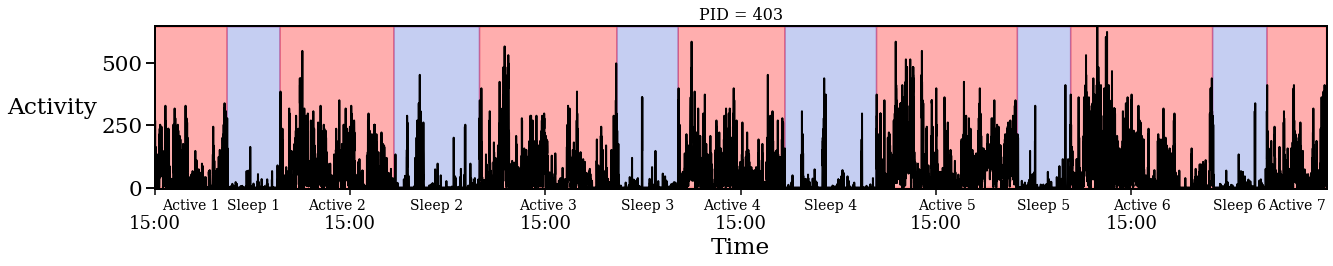

(<AxesSubplot:title={'center':'PID = 403'}, xlabel='Time', ylabel='Activity'>,
 <module 'matplotlib.pyplot' from 'e:\\development\\sleep\\sleep\\lib\\site-packages\\matplotlib\\pyplot.py'>)

In [13]:
v.view_ml_format_in_one_row(w0, 
                            signal_categories = ["activity", "sleep"],
                            sleep_cols=["sleep_period_annotation"],
                            alphas = {'sleep': 0.3}, 
                            colors = None, 
                            edgecolors = None, 
                            labels = None)

In [ ]:
df = pd.DataFrame(dict(name=['Raphael', 'Donatello'],
                  mask=['red', 'purple'],
                  weapon=['sai', 'bo staff']))

In [ ]:
df = df.style.applymap(lambda _: 'background-color: yellow')

In [ ]:
df.render()

In [ ]:
pd.read_html('<style  type="text/css" >\n#T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow0_col0,#T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow0_col1,#T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow0_col2,#T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow1_col0,#T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow1_col1,#T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow1_col2{\n            background-color:  yellow;\n            background-color:  yellow;\n            background-color:  yellow;\n        }</style><table id="T_2ab54e01_702c_11eb_a15c_a4c3f07b747d" ><thead>    <tr>        <th class="blank level0" ></th>        <th class="col_heading level0 col0" >name</th>        <th class="col_heading level0 col1" >mask</th>        <th class="col_heading level0 col2" >weapon</th>    </tr></thead><tbody>\n                <tr>\n                        <th id="T_2ab54e01_702c_11eb_a15c_a4c3f07b747dlevel0_row0" class="row_heading level0 row0" >0</th>\n                        <td id="T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow0_col0" class="data row0 col0" >Raphael</td>\n                        <td id="T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow0_col1" class="data row0 col1" >red</td>\n                        <td id="T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow0_col2" class="data row0 col2" >sai</td>\n            </tr>\n            <tr>\n                        <th id="T_2ab54e01_702c_11eb_a15c_a4c3f07b747dlevel0_row1" class="row_heading level0 row1" >1</th>\n                        <td id="T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow1_col0" class="data row1 col0" >Donatello</td>\n                        <td id="T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow1_col1" class="data row1 col1" >purple</td>\n                        <td id="T_2ab54e01_702c_11eb_a15c_a4c3f07b747drow1_col2" class="data row1 col2" >bo staff</td>\n            </tr>\n    </tbody></table>'

)

In [ ]:
w0.data.hyp_time_col

In [ ]:
investigate_one_wearable('0347')

# Physical Activity <a id='physical_activity'></a>

In [ ]:
w0.data = w0.data[w0.data['hyp_exp_day'] <= 2]

In [ ]:

print("Calculating PA features")
pa_levels = ["sedentary", "light", "medium", "vigorous"]
value_vars = []

pa = PhysicalActivity(exp)
# METS: 1.5, 3, 6
pa.set_cutoffs(cutoffs=[58, 399, 1404], names=pa_levels)
pa.generate_pa_columns(based_on="activity")
bouts = []
for act_level in pa_levels:
    print(act_level)
    tmp_list = []
    for length in [5, 10, 15, 20]:
        tmp_list.append(pa.get_bouts(act_level, length, length // 2,
                                     resolution="hour", sleep_col="sleep_period_annotation"))
    tmp_list = pd.concat(tmp_list)
    if not tmp_list.empty:
        value_vars.append(act_level)
        bouts.append(tmp_list)

# Merge PA datasets
bouts = functools.reduce(
    lambda left, right: pd.merge(left, right, on=["pid", exp_day_column, "hyp_time_col", "bout_length"],
                                 how='outer'), bouts).fillna(0.0)

print('-------Done getting bouts--------')

# bouts_melted = bouts.melt(id_vars=["pid", exp_day_column, "bout_length"],
#                           value_vars=value_vars)

bouts['hyp_time_col'] = pd.Categorical(bouts['hyp_time_col'], ordered=True, categories=range(24))
# Make sure that this wont happen
bouts = bouts[bouts[exp_day_column] != -1]

# TODO: bouts_per_hour need to be saved as well
bouts_per_hour = bouts.groupby(['pid', exp_day_column, 'hyp_time_col', 'bout_length'])[value_vars].mean().fillna(0)

bouts_per_day = bouts_per_hour.groupby(['pid', exp_day_column, 'bout_length']).sum() # Total number of bouts per day
bouts_per_day = bouts_per_day.pivot_table(index=['pid', exp_day_column],
                                          columns=['bout_length'],
                                          values=value_vars)
# Flatten hierarchical column names
bouts_per_day.columns = ['_'.join(map(str, col)).strip() for col in bouts_per_day.columns.values]

pa_bins = pa.get_binned_pa_representation()
pa_bins_per_hour = pa_bins.pivot_table(index=['pid', exp_day_column, "hyp_time_col"])
pa_bins_per_day = pa_bins.pivot_table(index=['pid', exp_day_column])

pa_stats = pa.get_stats_pa_representation()
pa_stats_per_hour = pa_stats.pivot_table(index=['pid', exp_day_column, "hyp_time_col"])
pa_stats_per_day = pa_stats.pivot_table(index=['pid', exp_day_column])

pa_raw_per_hour = pa.get_raw_pa("hour")
pa_raw_per_hour = pa_raw_per_hour.set_index(['pid', exp_day_column, "hyp_time_col"])
#pa_raw_per_hour["raw_pa"] = pa_raw_per_hour["raw_pa"].apply(lambda x: ','.join(x.astype(str)))

pa_raw_per_day = pa.get_raw_pa("day")
pa_raw_per_day = pa_raw_per_day.set_index(['pid', exp_day_column])
pa_raw_per_day["raw_pa"] = pa_raw_per_day["raw_pa"].apply(lambda x: ','.join(x.astype(str)))

elapsed_time = check_time(elapsed_time)
print("Done with PA features...")

# Sleep Analysis
print("Calculating Sleep Metrics")
sm = SleepMetrics(exp)
sleep_metrics = ["sleepEfficiency", "totalSleepTime"]
sleep_metrics_per_day = []
for sleep_metric in sleep_metrics:
    sleep_metrics_per_day.append(sm.get_sleep_quality(sleep_metric=sleep_metric, wake_sleep_col="sleep",
                                                      sleep_period_col="sleep_period_annotation"))

sleep_metrics.append("awakening")
sleep_metrics_per_day.append(sm.get_sleep_quality(sleep_metric="awakening", wake_sleep_col="sleep",
                                                  ignore_awakenings_smaller_than_X_minutes=5,
                                                  sleep_period_col="sleep_period_annotation"))

# SRI calculation will not work with set_ml_representation_days_exp because day representation will be of different lengths.
# While SRI requires the days to be of fixed lengths.
# sleep_metrics.append("sri")
# sleep_metrics.append(sm.get_sleep_quality(sleep_metric="sri", wake_sleep_col="sleep"))

sleep_metrics_per_day = functools.reduce(
    lambda left, right: pd.merge(left, right, on=["pid", exp_day_column], how='outer'),
    sleep_metrics_per_day)
sleep_metrics_per_day = sleep_metrics_per_day.set_index(['pid', 'ml_sequence'])[sleep_metrics]

elapsed_time = check_time(elapsed_time)
print("Done with sleep metrics...")

# Circadian Analysis
print("Running Circadian Analysis")
ca = CircadianAnalysis(exp)

cosinor_keys = ["amplitude", "acrophase", "mesor"]
cosinor_per_day = ca.run_cosinor()
cosinor_per_day = cosinor_per_day[cosinor_keys]

elapsed_time = check_time(elapsed_time)
print("Done with circadian features...")


In [ ]:
w0.data

# Demographics <a id='demographics'></a>

In [ ]:

# SSA is not yet ready to be used.
ssa = ca.run_SSA()
print("Calculating Demographic features")
demo = Demographics(file_path=path_to_demographics, pid_col=pid_col, save_only_cols=variables,
                    clock_features=clock_variables, dtype=None)
demo.data = demo.data.replace("S", np.nan).replace("Q", np.nan)
for col in demo.data.keys():
    demo.data[col] = demo.data[col].astype(np.float)

elapsed_time = check_time(elapsed_time)
print("Done with demographic features...")

# Time related features
print("Calculating Time related features")
weekend = exp.is_weekend()
weekday = exp.weekday()
time_features_per_day = pd.merge(weekend, weekday).set_index(["pid", exp_day_column])

elapsed_time = check_time(elapsed_time)
print("Done with time features...")


In [ ]:


day_keys = {"bins": list(pa_bins_per_day.keys()),
           "bouts": list(bouts_per_day.keys()),
           "stats": list(pa_stats_per_day.keys()),
           "raw": list(pa_raw_per_day.keys()),
           "sleep_metrics": sleep_metrics,
           "cosinor": cosinor_keys,
           "time": ["hyp_weekday", "hyp_is_weekend"]
           }

print("Merging representations")
data_representation_per_day = pd.merge(bouts_per_day, pa_bins_per_day, left_index=True, right_index=True).merge(
    pa_stats_per_day, left_index=True, right_index=True).merge(
    pa_raw_per_day, left_index=True, right_index=True).merge(
    sleep_metrics_per_day, left_index=True, right_index=True).merge(
    cosinor_per_day, left_index=True, right_index=True)
#.merge(
#    time_features_per_day, left_index=True, right_index=True
#)

data_representation_per_hour = pd.merge(bouts_per_hour, pa_bins_per_hour, left_index=True, right_index=True,
                                        suffixes=("_bouts", "_bins")).merge(
    pa_stats_per_hour, left_index=True, right_index=True).merge(
    pa_raw_per_hour, left_index=True, right_index=True
)
data_representation_per_pid = demo.get_valid_data_for_experiment(exp)

data_representation_per_day.to_csv("%s_per_day.csv" % DATA_COLLECTION)
data_representation_per_hour.to_csv("%s_per_hour.csv" % DATA_COLLECTION)
data_representation_per_pid.to_csv("%s_per_pid.csv" % DATA_COLLECTION)
day_keys = pd.Series(day_keys)
day_keys.index.name = "key"
day_keys.name = "value"
day_keys.to_csv("%s_day_keys.csv" % DATA_COLLECTION)

pd.Series(data_representation_per_day.reset_index()["pid"].unique(), name="pids").to_csv("%s_pid.csv" % DATA_COLLECTION, index=False)

check_time(start)
print("Done with all...")


# Investigate ml format sequence length <a id='sequence_length'></a>

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def wearable_get_ml_sequence_list(w):
    return w.data.groupby('ml_sequence')['hyp_act_x'].apply(list)

def wearable_get_ml_sequence_len(w):
    return w.data.groupby('ml_sequence')['hyp_act_x'].apply(len)

def get_ml_sequence_list(exp):
    ml_sequence_list = []
    for w in exp.get_all_wearables():
        wearable_ml_sequence = wearable_get_ml_sequence_list(w)
        wearable_ml_sequence_list = pd.DataFrame(wearable_ml_sequence_len).reset_index()
        wearable_ml_sequence_list['pid'] = w.get_pid()
        wearable_ml_sequence_list = wearable_ml_sequence_list[['pid', 'ml_sequence', 'hyp_act_x']]
        wearable_ml_sequence_list.columns = ['pid', 'ml_sequence', 'list']
        wearable_ml_sequence_list.set_index('pid')
        ml_sequence_list.append(wearable_ml_sequence_list)
    
    ml_sequence_list = pd.concat(ml_sequence_list)
    ml_sequence_list = ml_sequence_list.set_index('pid')
    return ml_sequence_list

def get_ml_sequence_len(exp):
    ml_sequence_len = []
    for w in exp.get_all_wearables():
        wearable_ml_sequence_len = wearable_get_ml_sequence_len(w)
        wearable_ml_sequence_len = pd.DataFrame(wearable_ml_sequence_len).reset_index()
        wearable_ml_sequence_len['pid'] = w.get_pid()
        wearable_ml_sequence_len = wearable_ml_sequence_len[['pid', 'ml_sequence', 'hyp_act_x']]
        wearable_ml_sequence_len.columns = ['pid', 'ml_sequence', 'len']
        ml_sequence_len.append(wearable_ml_sequence_len)
    
    ml_sequence_len = pd.concat(ml_sequence_len)
    ml_sequence_len = ml_sequence_len.set_index('pid')
    return ml_sequence_len

# wearable_get_ml_sequence_len(w0)

In [ ]:
sequences_length = get_ml_sequence_len(exp)

In [ ]:
print(sequences_length.groupby('pid')['ml_sequence'].count().describe())
print('==========')
print(sequences_length['len'].describe())
sequences_length['len'].plot.density()